In [1]:
import warnings

import os
import torch
import pickle
import numpy as np
import os.path as osp
from tqdm import tqdm

from functools import reduce
import torch.nn.functional as F
import matplotlib.pyplot as plt

from src.datasets import DatasetBuilder
from src.models.classifiers import SimpleCNNtorch
from src.models.vae import BetaVAE
from src.cf_methods import Revise
from src.evaluation.local_instability import perturb_sample
from src.utils import extract_factual_instances, filter_valid_factuals
from src.utils import seed_everything, get_config, load_model_weights
from src.utils import evaluate_classification_model, plot_boxplot

/data/leuven/365/vsc36567/miniconda3/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
2025-05-30 11:52:09.397043: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748598729.414414 1336372 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748598729.419627 1336372 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748598729.433526 1336372 computation_placer.cc:177] computation placer alrea

In [2]:
seed_everything()
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
config_path = r'/data/leuven/365/vsc36567/CF-Robustness-Benchmark/configs/revise_fmnist_binary.yaml'
# r"D:\PycharmProjects\CF-Robustness-Benchmark\configs\revise_mnist_binary.yaml"
config = get_config(config_path)

In [4]:
config.data.classes = [0, 2, 4, 6]
config.data.num_classes = len(config.data.classes)
config.vae.checkpoints_path = "/data/leuven/365/vsc36567/CF-Robustness-Benchmark/notebooks/experiments/fmnist_vae/multiclass/checkpoints/fmnist__epoch=34.pth"

In [19]:
config.save_dir = '/data/leuven/365/vsc36567/CF-Robustness-Benchmark/cf_output/fmnist/revise_multiclass'

In [5]:
ds_builder = DatasetBuilder(config)
ds_builder.setup()
train_loader, val_loader, test_loader = ds_builder.get_dataloaders()

In [6]:
os.makedirs(config.save_dir, exist_ok=True)
class_names = ds_builder.class_encodings
classes4fname = ("_").join([str(i) for i in class_names.values()]) if config.data.num_classes == 2 else ""
ds_name = config.data.name

### Load the classifier and VAE

In [7]:
device = config.accelerator
config.classifier.checkpoints_path = r'/data/leuven/365/vsc36567/CF-Robustness-Benchmark/notebooks/experiments/fmnist_classification/multiclass/checkpoints/fmnist__epoch=12_val_accuracy=0.84.pth'
baseline_classifier = SimpleCNNtorch(**config.classifier.args,
                                    num_classes=config.data.num_classes,
                                    img_size=config.data.img_size)
load_model_weights(baseline_classifier, weights_path=config.classifier.checkpoints_path, lightning_used=True)
evaluate_classification_model(baseline_classifier, test_loader, config.data.num_classes)
baseline_classifier = baseline_classifier.to(device)

Accuracy for the test dataset: 81.994%


In [8]:
vae = BetaVAE(**config.vae.args, input_size=(config.data.img_size, config.data.img_size))
config.vae.checkpoints_path = r"/data/leuven/365/vsc36567/CF-Robustness-Benchmark/notebooks/experiments/fmnist_vae/multiclass/checkpoints/fmnist__epoch=34.pth"
load_model_weights(vae, weights_path=config.vae.checkpoints_path, lightning_used=True)

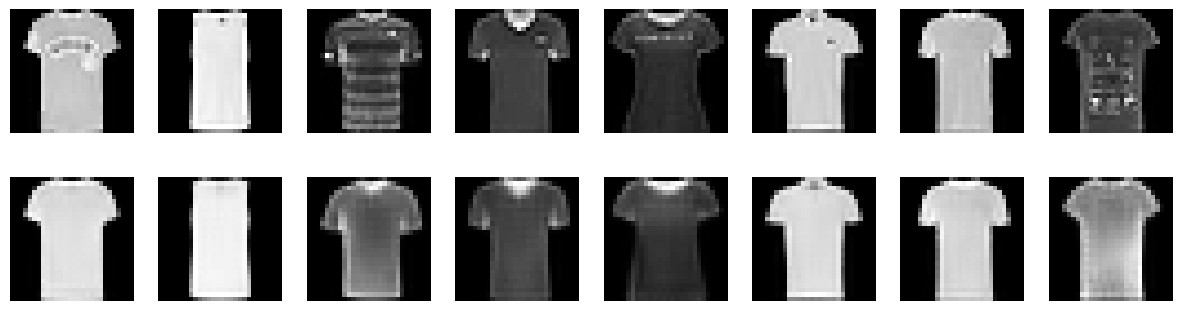

In [9]:
vae = vae.to(device)
vae.eval()
with torch.no_grad():
    images, _ = next(iter(test_loader))
    images = images.to(device)

    z, _ = vae.encoder(images)
    recon_images = vae.decoder(z)
    recon_images = recon_images.to(device)

    # plot reconstructed images
    _, axes = plt.subplots(2, 8, figsize=(15, 4))
    for i in range(8):
        axes[0, i].imshow(images[i].permute(1, 2, 0).cpu().squeeze(), cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon_images[i].permute(1, 2, 0).cpu().squeeze(), cmap='gray')
        axes[1, i].axis('off')

### Preparing factual test instances and their perturbed versions

In [10]:
factuals, labels = extract_factual_instances(test_loader, init_class_idx=[0, 2, 6])
factuals, labels = filter_valid_factuals(factuals, labels, baseline_classifier, device)

In [11]:
# Checking for correctly predicted factuals 
preds = torch.argmax(baseline_classifier(factuals.to(device)), axis=1).detach().cpu()
print('Accuracy: {:.0%}'.format(torch.where(preds == labels)[0].shape[0] / factuals.shape[0]))

Accuracy: 100%


In [12]:
noise_magnitudes = [0.001, 0.0025, 0.005, 0.0075, 0.01]

Prepare perturbed factual instances for the generation of CFEs. We need those perturbed factuals that
are predicted correctly by the classifier

In [13]:
n = 100
factuals_pert = {}
indices_pert = {}

for noise in noise_magnitudes:
    pert_sample = perturb_sample(factuals, n_samples=1, noise_magnitude=noise)
    pert_sample = torch.Tensor(pert_sample)

    # Check whether perturbed instances lead to the same class prediction
    predictions = torch.argmax(baseline_classifier(pert_sample.to(device)), axis=1).detach().cpu()
    indices = np.where(predictions == labels)[0]
    print(f'Number of valid perturbed factuals for the added noise level {noise}: ', indices.shape[0])
    factuals_pert[noise] = pert_sample
    indices_pert[noise] = indices

final_indices = reduce(np.intersect1d, list(indices_pert.values()))
factuals_pert = {k : v[final_indices][:n] for k, v in factuals_pert.items()}
factuals = factuals[final_indices][:n]
labels = labels[final_indices][:n]

Number of valid perturbed factuals for the added noise level 0.001:  1695
Number of valid perturbed factuals for the added noise level 0.0025:  1654
Number of valid perturbed factuals for the added noise level 0.005:  1620
Number of valid perturbed factuals for the added noise level 0.0075:  1609
Number of valid perturbed factuals for the added noise level 0.01:  1596


Visualize the factual instances perturbed with different noise magnitude

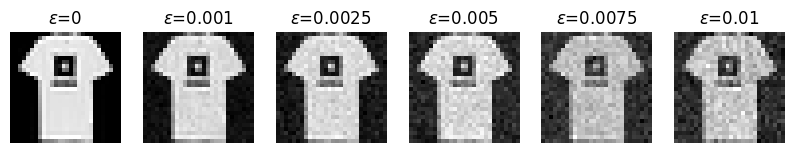

In [14]:
ind = 10
n_rows = 1
n_cols = len(noise_magnitudes) + 1
fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 4))

for j in range(n_cols):
    if j == 0: 
        axs[j].imshow(factuals[ind].squeeze().squeeze(), cmap='gray')
        axs[j].set_title('$\\epsilon$=0') 
        axs[j].axis('off')
    else:
        noise = noise_magnitudes[j-1]
        pert_image = factuals_pert[noise][ind].squeeze().squeeze() 
        axs[j].imshow(pert_image, cmap='gray')
        axs[j].set_title('$\\epsilon$='+str(noise)) 
        axs[j].axis('off')
        
plt.show()

# Generate CFEs

In [15]:
target_class = 4
target_class_ind = 2
hparams = config.revise_hyperparameters
hparams['max_iter'] = 1000
hparams['lambda'] = 0.05
hparams['target_class_ind'] = np.zeros((1, config.data.num_classes))
hparams['target_class_ind'][0, target_class_ind] = 1
revise_method = Revise(baseline_classifier, vae, hparams)
hparams['target_class_ind']

array([[0., 0., 1., 0.]])

In [18]:
cfes = revise_method.get_counterfactuals(factuals, verbose=False)

100%|██████████| 100/100 [05:44<00:00,  3.44s/it]


In [20]:
fname = f'cfes_{ds_name.lower()}_{target_class}.pkl'
with open(osp.join(config.save_dir, fname), 'wb') as f:
    pickle.dump(cfes, f)

Read already generated CFEs

In [16]:
fname = f'cfes_{ds_name.lower()}_{target_class}.pkl'
with open(osp.join(config.save_dir, fname), 'rb') as f:
    cfes = pickle.load(f)

In [22]:
cfes_pert = {} 

for noise in noise_magnitudes:
    cfes_pert[noise] = revise_method.get_counterfactuals(factuals_pert[noise], verbose=False)
    fname = f'cfes_{ds_name.lower()}_{target_class}_noise_{noise}.pkl'
    with open(osp.join(config.save_dir, fname), 'wb') as f:
        pickle.dump(cfes_pert[noise], f)

100%|██████████| 100/100 [05:30<00:00,  3.31s/it]


Read already generated perturbed CFEs

In [18]:
cfes_pert = {} 

for noise in noise_magnitudes:
    fname = f'cfes_{ds_name.lower()}_{target_class}_noise_{noise}.pkl'
    with open(osp.join(config.save_dir, fname), 'rb') as f:
        cfes_pert[noise] = pickle.load(f)

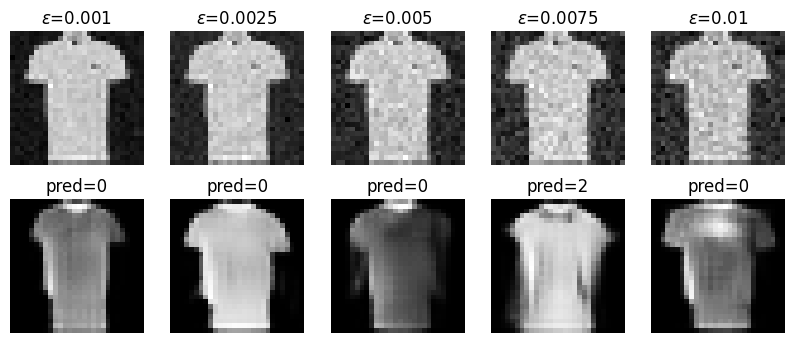

In [22]:
n_rows = 2
n_cols = 5

ind = 5

fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 4))
for i in range(n_rows):
    for j in range(n_cols):
        noise = noise_magnitudes[j]
        if i == 0: 
            pert_image = factuals_pert[noise][ind].squeeze().squeeze() 
            axs[i, j].imshow(pert_image, cmap='gray')
            axs[i, j].set_title('$\\epsilon$='+str(noise)) 
            axs[i, j].axis('off')
        # elif i == 1:
        #     axs[i, j].imshow(cfes[ind].squeeze(), cmap='gray')
        #     axs[i, j].axis('off')
        #     axs[i, j].set_ylabel('CFE /wo noise')
        else:
            axs[i, j].imshow(cfes_pert[noise][ind].transpose(1, 2, 0), cmap='gray')
            pred_class = class_names[torch.argmax(baseline_classifier(torch.Tensor(cfes_pert[noise][ind]).unsqueeze(0).to(device))).item()]
            axs[i, j].set_title('pred='+str(pred_class))
            # axs[i, j].set_title('epsilon='+str(noise)) 
            axs[i, j].axis('off')
            axs[i, j].set_ylabel('CFE /w noise')
plt.show()

## Local Instability

In [32]:
from src.evaluation.local_instability import calculate_sparsity, calculate_ssim

Checking validity of explanations after perturbation

In [34]:
validity = 0
for cfe in cfes:
    if len(cfe) !=0:
        pred = torch.argmax(baseline_classifier(torch.Tensor(cfe).unsqueeze(0).to(device)), axis=1).detach().cpu()
        if pred == target_class_ind:    
            validity += 1
validity /= len(cfes)
print('Initial validity: ', validity)

Initial validity:  0.66


In [35]:
target_cls_ind = 2

validity_list = []
for noise in noise_magnitudes:
    predictions = []
    validity = 0
    total_cfes_found = len(cfes_pert[noise])
    for i, cfe_pert in enumerate(cfes_pert[noise]):
        if len(cfe_pert) == 0:
            continue

        predictions = torch.argmax(baseline_classifier(torch.Tensor(cfe_pert).unsqueeze(0).to(device)), axis=1).detach().cpu()
        if predictions == target_cls_ind: 
            validity += 1 
    validity /= total_cfes_found
    validity_list.append(validity) 
    print(f'Validity for the added noise level {noise}: ',  validity)

fname = f'{ds_name.lower()}_{target_class}_validity.pkl'
with open(osp.join(config.save_dir, fname), 'wb') as f:
    pickle.dump(validity_list, f)

Validity for the added noise level 0.001:  0.74
Validity for the added noise level 0.0025:  0.83
Validity for the added noise level 0.005:  0.87
Validity for the added noise level 0.0075:  0.85
Validity for the added noise level 0.01:  0.85


In [36]:
instability_l1_list = []
ssim_list = []

for noise, cfe_pert_list in cfes_pert.items():
    l1_temp = []
    ssim_temp = []
    for i in range(len(cfes)):
        cf = cfes[i]
        cf_pert = cfe_pert_list[i]

        if len(cf) != 0 and len(cf_pert) != 0:

            cf_tensor = torch.Tensor(cf)
            cf = cf_tensor.permute(1, 2, 0).flatten()

            cf_pert_tensor = torch.Tensor(cf_pert)
            cf_perturbed = cf_pert_tensor.permute(1, 2, 0).flatten()        

            l1_distance = sum(abs(cf - cf_perturbed)).item() # np.linalg.norm(cf.flatten() - cf_perturbed.flatten(), ord=1)
            l1_temp.append(l1_distance)

            ssim = calculate_ssim(cf_tensor.unsqueeze(0), cf_pert_tensor.unsqueeze(0)).item()
            ssim_temp.append(ssim)

    instability_l1_list.append(l1_temp)
    ssim_list.append(ssim_temp)

with open(osp.join(config.save_dir, f'{ds_name.lower()}_{target_class}_li_l1.pkl'), 'wb') as f:
    pickle.dump(instability_l1_list, f)

with open(osp.join(config.save_dir, f'{ds_name.lower()}_{target_class}_ssim.pkl'), 'wb') as f:
    pickle.dump(ssim_list, f)

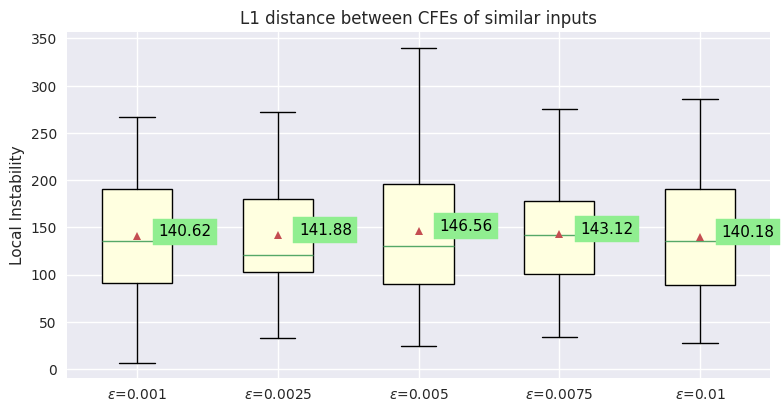

In [37]:
import pandas as pd
plt.style.use("seaborn-v0_8")
plt.rcParams['figure.figsize'] = [8, 4]

plot_boxplot(data=instability_l1_list, mean_values=[np.mean(li).round(2) for li in instability_l1_list],
            tick_labels=[f'$\\epsilon$={noise_level}' for noise_level in noise_magnitudes],
            y_label='Local Instability', colors=['lightyellow'], 
            title='L1 distance between CFEs of similar inputs')

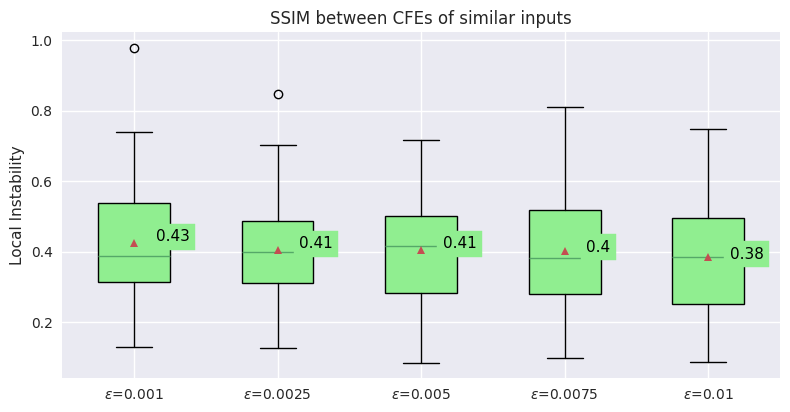

In [38]:
plot_boxplot(data=ssim_list, mean_values=[np.mean(li).round(2) for li in ssim_list],
             tick_labels=[f'$\\epsilon$={noise_level}' for noise_level in noise_magnitudes],
             y_label='Local Instability', colors=['lightgreen'], title='SSIM between CFEs of similar inputs')

## Local Lipschitz Continuity

In [23]:
original_points = factuals
original_cfes = cfes
print("Are the lengths of initial points (factuals) and CFEs generated for them equal :", len(original_cfes) == original_points.shape[0])

Are the lengths of initial points (factuals) and CFEs generated for them equal : True


In [32]:
noise_magnitude = 0.001
n_samples = 15
# revise_method._params["max_iter"] = 1000

lip_estimates = []

i = 0
for original_point, original_cfe in tqdm(zip(original_points[n_samples:], original_cfes[n_samples:])):
    if isinstance(original_cfe, list):
        continue

    neighbor_points = perturb_sample(original_point.unsqueeze(0), 
                                    n_samples=30, 
                                    noise_magnitude=noise_magnitude)    
    neighbor_points = torch.Tensor(neighbor_points)
    neighbor_cfes = revise_method.get_counterfactuals(neighbor_points, verbose=False)

    lip_estimate = 0
    for m, p in tqdm(zip(neighbor_cfes, neighbor_points)):
        if not isinstance(m, list):
            num = np.linalg.norm((original_cfe - m).flatten(), ord=2) 
            denom = np.linalg.norm((original_point - p).flatten(), ord=2)
            lip = num / denom
            lip_estimate = max(lip, lip_estimate)

    lip_estimates.append(lip_estimate)
    i += 1

100%|██████████| 30/30 [01:40<00:00,  3.34s/it]
30it [00:00, 21013.55it/s]
100%|██████████| 30/30 [01:39<00:00,  3.32s/it]
30it [00:00, 8429.63it/s]
100%|██████████| 30/30 [01:38<00:00,  3.28s/it]
30it [00:00, 6593.78it/s]
100%|██████████| 30/30 [01:37<00:00,  3.27s/it]
30it [00:00, 105384.52it/s]
100%|██████████| 30/30 [01:39<00:00,  3.32s/it]
30it [00:00, 26013.88it/s]
100%|██████████| 30/30 [01:39<00:00,  3.31s/it]
30it [00:00, 23541.46it/s]
100%|██████████| 30/30 [01:39<00:00,  3.33s/it]
30it [00:00, 26368.21it/s]
100%|██████████| 30/30 [01:38<00:00,  3.28s/it]
30it [00:00, 66682.10it/s]
100%|██████████| 30/30 [01:39<00:00,  3.33s/it]
30it [00:00, 23207.14it/s]
 77%|███████▋  | 23/30 [01:17<00:23,  3.39s/it]
10it [16:12, 97.24s/it]


KeyboardInterrupt: 

In [33]:
with open(osp.join(config.save_dir, f'{ds_name.lower()}_{target_class}_lle_rest10.pkl'), 'wb') as f:
        pickle.dump(lip_estimates, f)

In [31]:
f'{ds_name.lower()}_{target_class}_lle.pkl', config.save_dir

('fmnist_4_lle.pkl',
 '/data/leuven/365/vsc36567/CF-Robustness-Benchmark/cf_output/fmnist/revise_multiclass')

## Invalidation Rate

In [39]:
classifiers_weights_dir = r'/data/leuven/365/vsc36567/CF-Robustness-Benchmark/notebooks/experiments/fmnist_classification/multiclass/checkpoints/mc_all'
# r"/data/leuven/365/vsc36567/CF-Robustness-Benchmark/notebooks/experiments/fmnist_classification/multiclass/checkpoints/mc_all"
# r"/data/leuven/365/vsc36567/CF-Robustness-Benchmark/notebooks/experiments/mnist_classification/binary/checkpoints/mc_1_7"


classifiers_list = []
for clf_weights in os.listdir(classifiers_weights_dir):
    cnn_perturbed = SimpleCNNtorch(**config.classifier.args,
                                    num_classes=config.data.num_classes,
                                    img_size=config.data.img_size)
    # load_model_weights(model=cnn_perturbed, 
    #                     weights_path=osp.join(classifiers_weights_dir, clf_weights))
    checkpoint = torch.load(
                    osp.join(classifiers_weights_dir, clf_weights), weights_only=False,
                    map_location=torch.device(device)
                )
            
    cnn_perturbed.load_state_dict(checkpoint)
    classifiers_list.append(cnn_perturbed)
    print(clf_weights)
    evaluate_classification_model(cnn_perturbed, 
                                    dataloader=test_loader, 
                                    num_classes=config.data.num_classes)

fmnist__3261.pth
Accuracy for the test dataset: 81.176%
fmnist__1013.pth
Accuracy for the test dataset: 80.680%
fmnist__2913.pth
Accuracy for the test dataset: 81.052%
fmnist__2067.pth
Accuracy for the test dataset: 81.597%
fmnist__1334.pth
Accuracy for the test dataset: 79.886%
fmnist__2828.pth
Accuracy for the test dataset: 81.076%
fmnist__2915.pth
Accuracy for the test dataset: 79.712%
fmnist__2334.pth
Accuracy for the test dataset: 81.672%
fmnist__1967.pth
Accuracy for the test dataset: 80.556%
fmnist__2279.pth
Accuracy for the test dataset: 80.630%


In [43]:
validity_list = []
invalidation_rate_list = []

for i, classifier in enumerate(classifiers_list):
    validity = 0
    invalidation_rate = 0
    total_found_cfs = 0
    
    for cfe in cfes:
        if isinstance(cfe, list):
            continue
        
        cfe = torch.Tensor(cfe).unsqueeze(0).to(device)
        classifier.eval()
        with torch.no_grad():
            classifier = classifier.to(device)

            baseline_pred = torch.argmax(baseline_classifier(cfe), axis=1)
            alternative_pred = torch.argmax(classifier(cfe), axis=1)

        total_found_cfs += 1

        if baseline_pred != alternative_pred:
            invalidation_rate += 1

        if alternative_pred == target_class_ind:
                validity += 1

    invalidation_rate /= total_found_cfs
    validity /= total_found_cfs

    invalidation_rate_list.append(invalidation_rate)
    validity_list.append(validity)
    print(f'Model {i}: IR={np.round(invalidation_rate, 4)}, validity={np.round(validity, 4)}')

print('Average IR : {:.3f} +- {:.3f}'.format(np.mean(invalidation_rate_list), np.std(invalidation_rate_list)))
print('Average VaR : {:.3f} +- {:.3f}'.format(np.mean(validity_list), np.std(validity_list)))

Model 0: IR=0.9545, validity=0.0455
Model 1: IR=0.9848, validity=0.0152
Model 2: IR=0.9242, validity=0.0758
Model 3: IR=0.9242, validity=0.0758
Model 4: IR=0.9091, validity=0.0909
Model 5: IR=0.8182, validity=0.1818
Model 6: IR=0.9091, validity=0.0909
Model 7: IR=0.9697, validity=0.0303
Model 8: IR=0.9091, validity=0.0909
Model 9: IR=0.9697, validity=0.0303
Average IR : 0.927 +- 0.045
Average VaR : 0.073 +- 0.045


## Relaxed Stability

In [44]:
k = 1000
sigma = 0.001

average_stability_list = []
for i, classifier in enumerate(classifiers_list):
    stability_list = []
    for cfe in cfes:
        if isinstance(cfe, list):
            continue

        cfe = torch.Tensor(cfe).unsqueeze(0)
        cfe_sampled = torch.Tensor(perturb_sample(cfe, n_samples=k, noise_magnitude=sigma))

        with torch.no_grad():
            cf_logits = classifier(cfe.to(device))
            cf_probabilities = F.softmax(cf_logits, dim=-1)[:, target_class_ind]

            cf_sampled_logits = classifier(cfe_sampled.to(device))
            cf_sampled_probabilities = F.softmax(cf_sampled_logits, dim=-1)[:, target_class_ind]
        
        model_variance = abs(cf_probabilities - cf_sampled_probabilities)

        stability = (cf_sampled_probabilities - model_variance).mean()
        stability_list.append(stability.item())

    avg_i_stability = np.mean(stability_list)
    print('Stability of the model {}: {:.3f} +- {:.3f}'.format(i, avg_i_stability.item(), np.std(stability_list).item()))
    average_stability_list.append(avg_i_stability)

Stability of the model 0: 0.046 +- 0.114
Stability of the model 1: 0.035 +- 0.076
Stability of the model 2: 0.064 +- 0.144
Stability of the model 3: 0.068 +- 0.133
Stability of the model 4: 0.082 +- 0.144
Stability of the model 5: 0.125 +- 0.209
Stability of the model 6: 0.068 +- 0.136
Stability of the model 7: 0.052 +- 0.126
Stability of the model 8: 0.074 +- 0.125
Stability of the model 9: 0.039 +- 0.097


In [47]:
print('Average RS: {:.3f} +- {:.3f}'.format(np.mean(average_stability_list), np.std(average_stability_list)))

Average RS: 0.065 +- 0.025


## LOF

In [48]:
from src.evaluation.lof import estimate_anom_cfe_in_target_class

In [53]:
cfes_array = np.array([cfe for cfe in cfes if not isinstance(cfe, list)])
cfes_array.shape

(66, 1, 28, 28)

In [54]:
target_class_ascores, target_class_classes = estimate_anom_cfe_in_target_class(5, [2], -1.1, test_loader, cfes_array)
print('Average negative LOF (the lower values the more anomaluous): {:.3f} +- {:.3f}'.format(np.mean(target_class_ascores), 
                                                                                            np.std(target_class_ascores)))

Average negative LOF (the lower values the more anomaluous): -1.441 +- 0.405


In [55]:
anomaly_scores, anomaly_classes = estimate_anom_cfe_in_target_class(5, [0, 1, 2, 3], -1.1, test_loader, cfes_array)
print('Average negative LOF (the lower values the more anomaluous): {:.3f} +- {:.3f}'.format(np.mean(anomaly_scores), np.std(anomaly_scores)))

Average negative LOF (the lower values the more anomaluous): -1.183 +- 0.209


In [ ]:
# couldn't save bc of the finished session 
with open(osp.join(save_dir, f'fmnist_{target_class}_ir_var_rs_lof.pkl'), 'wb') as f:
    pickle.dump({'ir': (np.mean(invalidation_rate_list), np.std(invalidation_rate_list)),
                'var': (np.mean(validity_list), np.std(validity_list)),
                'rs': (np.mean(average_stability_list), np.std(average_stability_list)),
                'lof_target_class': (np.mean(target_class_ascores), np.std(target_class_ascores)),
                'lof_test_set': (np.mean(anomaly_scores), np.std(anomaly_scores))
                }, f)